# **Segmentação de clientes**

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# pip install yellowbrick

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

In [2]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [3]:
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

## Carregamento e análise de dados

In [4]:
df_vendas = pd.read_csv('data/tfvenda.csv')
df_clientes = pd.read_csv('data/DimCliente.csv')
df_produtos = pd.read_csv('data/DimProduto.csv')
df_tempo = pd.read_csv('data/DimTempo.csv')

In [5]:
df_vendas

,VendaId,DataId,ClienteId,ProdutoId,Quantidade,PrecoUnitario,PercentagemDesconto,ValorTotal,Canal
0,1,2012-11-24,453,64,3,84.55,4.0,253.65,Loja Física
1,2,2010-11-24,113,140,5,161.37,25.0,806.85,Loja Física
2,3,2010-07-07,202,27,4,62.03,13.0,248.11,Loja Física
3,4,2019-05-10,560,123,5,214.03,49.0,1070.15,Loja Física
4,5,2019-04-15,168,21,4,129.40,29.0,517.58,Loja Física
...,...,...,...,...,...,...,...,...,...
15878,17879,2022-09-01,1094,90,2,642.87,21.0,1285.73,Online
15879,17880,2024-01-27,1298,61,1,203.33,16.0,203.33,Online
15880,17881,2021-03-19,2032,123,3,165.25,44.0,495.74,Online
15881,17882,2023-01-09,458,22,5,206.56,5.0,1032.80,Online


In [6]:
df_clientes

,ClienteId,Nome,Sexo,EstadoCivil,Profissao,Concelho,Distrito,DataNascimento
0,100,João Garcia,M,Divorciado,Comerciante,Celorico de Basto,Braga,1985-10-26
1,101,Gustavo Andrade,M,Solteiro,Analista de Dados,Vizela,Braga,1947-05-31
2,102,Salomé Matos,F,Divorciado,Gestor de Projetos,Póvoa de Varzim,Porto,2004-10-17
3,103,Anita de Silva,F,Casado,Cozinheiro,Sabugal,Guarda,1987-03-23
4,104,Diana Castro-Nogueira,F,Casado,Técnico de Marketing,Bragança,Bragança,1956-09-25
...,...,...,...,...,...,...,...,...
1986,2095,Miguel Antunes,M,Viúvo,Técnico de Marketing,Guarda,Guarda,1997-08-08
1987,2096,Isabel Cardoso,F,Viúvo,Carpinteiro,Celorico de Basto,Braga,1989-05-05
1988,2097,Nádia Carneiro,F,Viúvo,Farmacêutico,Braga,Braga,1997-11-03
1989,2098,Brian Costa,M,Casado,Programador,Valongo,Porto,1994-06-05


In [7]:
df_produtos

,ProdutoId,Nome,Marca,Categoria
0,1,Rato Logitech MX Master,Logitech,Perifericos
1,2,Logitech Rato MX Anywhere,Logitech,Perifericos
2,3,Teclado Mecânico Corsair K70,Corsair,Perifericos
3,4,Teclado Gaming Razer BlackWidow,Razer,Perifericos
4,5,"Monitor Dell 24"",Dell,Monitores\n6,Monitor 27 ...",HP,Monitores
...,...,...,...,...
168,171,Rato SteelSeries Rival 5,Logitech,Perifericos
169,172,Teclado Razer Pro Type,Acer,Monitores
170,173,"Monitor 27 ASUS ProArt""",BenQ,Monitores
171,174,Headset Sennheiser HD 560S,Sony,Audio


In [8]:
df_tempo

,DataId,Mes,Trimestre,Ano,FimDeSemana,Feriado
0,2010-01-01,1,1,2010,N,S
1,2010-01-02,1,1,2010,S,N
2,2010-01-03,1,1,2010,S,N
3,2010-01-04,1,1,2010,N,N
4,2010-01-05,1,1,2010,N,N
...,...,...,...,...,...,...
5177,2025-04-07,4,2,2025,N,N
5178,2025-04-08,4,2,2025,N,N
5179,2025-04-09,4,2,2025,N,N
5180,2025-04-10,4,2,2025,N,N


In [9]:
df_vendas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15883 entries, 0 to 15882
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   VendaId              15883 non-null  int64  
 1   DataId               15883 non-null  object 
 2   ClienteId            15883 non-null  int64  
 3   ProdutoId            15883 non-null  int64  
 4   Quantidade           15883 non-null  int64  
 5   PrecoUnitario        15883 non-null  float64
 6   PercentagemDesconto  15883 non-null  float64
 7   ValorTotal           15883 non-null  float64
 8   Canal                15883 non-null  object 
dtypes: float64(3), int64(4), object(2)
memory usage: 1.1+ MB


In [10]:
df_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1991 entries, 0 to 1990
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ClienteId       1991 non-null   int64 
 1   Nome            1991 non-null   object
 2   Sexo            1991 non-null   object
 3   EstadoCivil     1991 non-null   object
 4   Profissao       1991 non-null   object
 5   Concelho        1991 non-null   object
 6   Distrito        1991 non-null   object
 7   DataNascimento  1991 non-null   object
dtypes: int64(1), object(7)
memory usage: 124.6+ KB


In [11]:
df_produtos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ProdutoId  173 non-null    int64 
 1   Nome       173 non-null    object
 2   Marca      173 non-null    object
 3   Categoria  173 non-null    object
dtypes: int64(1), object(3)
memory usage: 5.5+ KB


In [12]:
df_tempo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5182 entries, 0 to 5181
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   DataId       5182 non-null   object
 1   Mes          5182 non-null   int64 
 2   Trimestre    5182 non-null   int64 
 3   Ano          5182 non-null   int64 
 4   FimDeSemana  5182 non-null   object
 5   Feriado      5182 non-null   object
dtypes: int64(3), object(3)
memory usage: 243.0+ KB


## Limpeza e transformação de dados

### Missing values

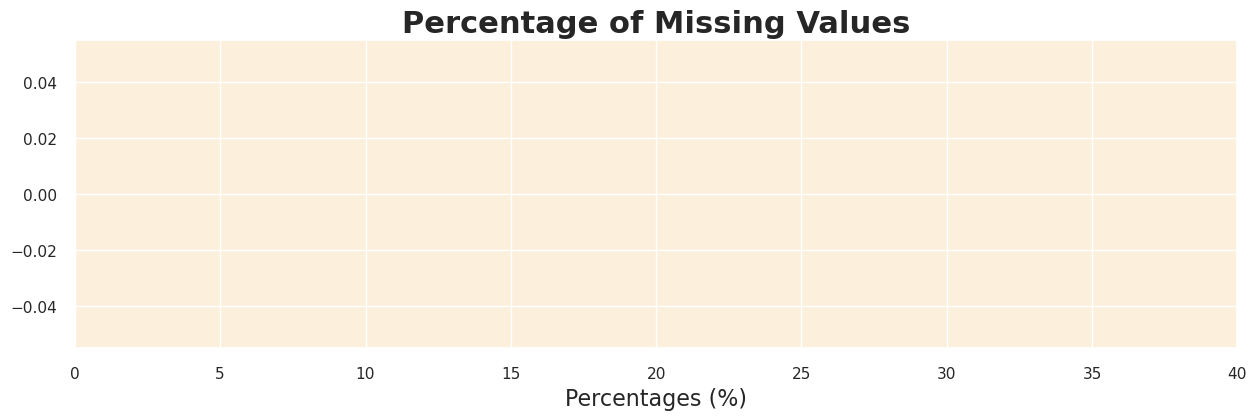

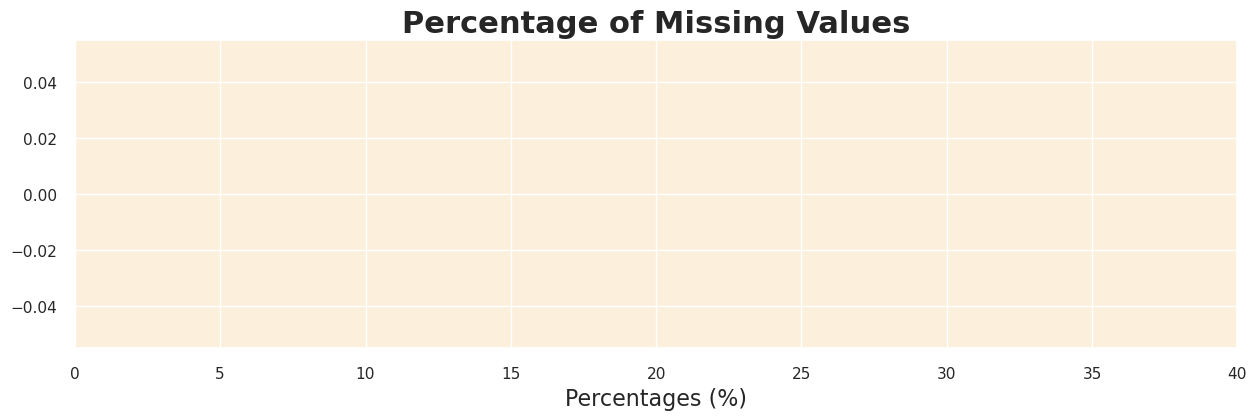

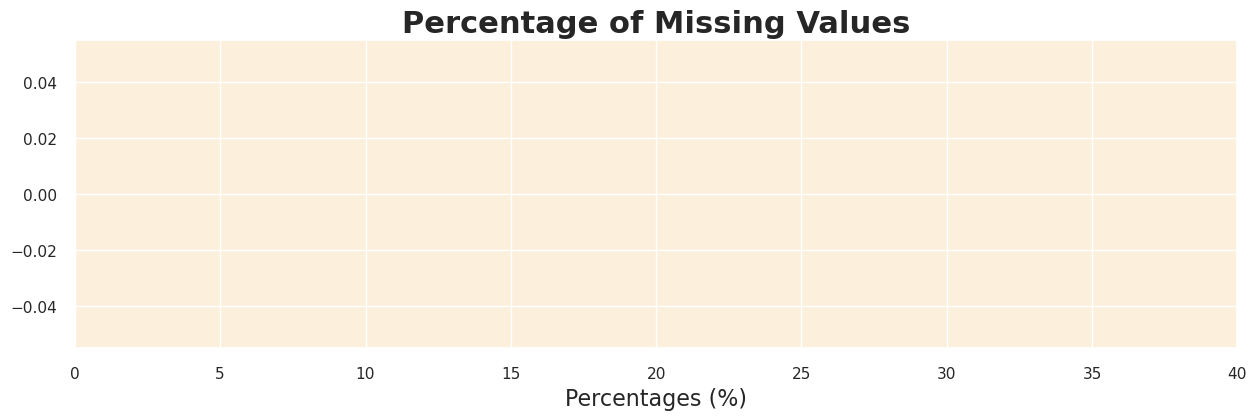

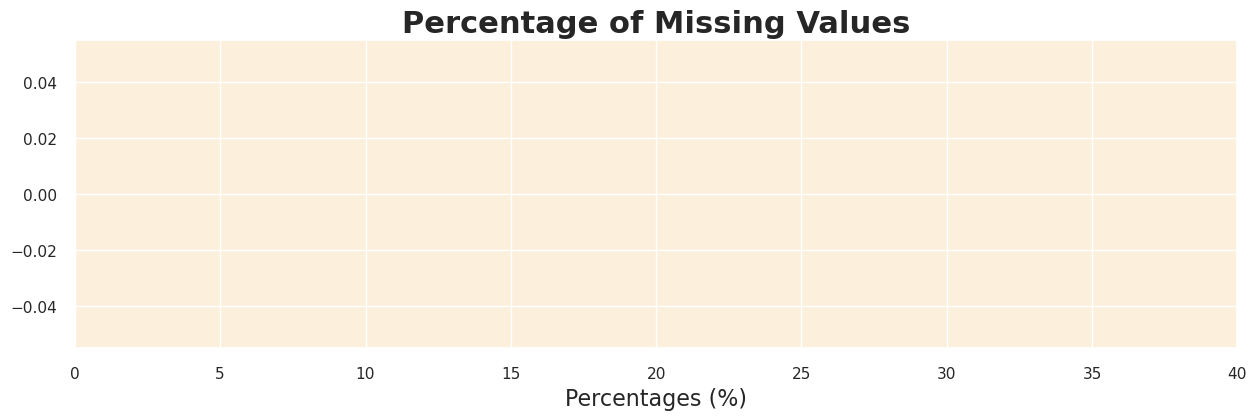

In [13]:
dfs = [df_vendas, df_clientes, df_produtos, df_tempo]

for df in dfs:
    missing_data = df.isnull().sum()
    missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

    missing_percentage.sort_values(ascending=True, inplace=True)

    fig, ax = plt.subplots(figsize=(15, 4))
    ax.barh(missing_percentage.index, missing_percentage, color='#ff6200')

    for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
        ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

    ax.set_xlim([0, 40])

    plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
    plt.xlabel('Percentages (%)', fontsize=16)
    plt.show()

In [14]:
for df in dfs:
    df.isnull().sum().sum()

### Duplicados

In [15]:
for df in dfs:
    duplicate_rows = df[df.duplicated(keep=False)]
    duplicate_rows.head(10)
    if duplicate_rows.empty:
        print(f"No duplicate rows in {df.columns[0]}")

No duplicate rows in VendaId
No duplicate rows in ClienteId
No duplicate rows in ProdutoId
No duplicate rows in DataId


## Feature engineering

### PrecoFinal
Preço final de uma compra considerando a quntidade, preço unitário e o desconto por unidade

In [16]:
df_vendas['PrecoFinal'] = df_vendas['PrecoUnitario'] * df_vendas['Quantidade'] * (1 - df_vendas['PercentagemDesconto']/100)
df_vendas.head(3)

,VendaId,DataId,ClienteId,ProdutoId,Quantidade,PrecoUnitario,PercentagemDesconto,ValorTotal,Canal,PrecoFinal
0,1,2012-11-24,453,64,3,84.55,4.0,253.65,Loja Física,243.5040
1,2,2010-11-24,113,140,5,161.37,25.0,806.85,Loja Física,605.1375
2,3,2010-07-07,202,27,4,62.03,13.0,248.11,Loja Física,215.8644


### Frequencia
Total de transações e de produtos comprados

In [17]:
total_transacoes = df_vendas.groupby('ClienteId')['VendaId'].nunique().reset_index()
total_transacoes.rename(columns={'VendaId': 'TotalTransacoes'}, inplace=True)

total_compras = df_vendas.groupby('ClienteId')['Quantidade'].sum().reset_index()
total_compras.rename(columns={'Quantidade': 'TotalCompras'}, inplace=True)

df_clientes = pd.merge(df_clientes, total_transacoes, on='ClienteId', how='left')
df_clientes = pd.merge(df_clientes, total_compras, on='ClienteId', how='left')

df_clientes.head(3)

,ClienteId,Nome,Sexo,EstadoCivil,Profissao,Concelho,Distrito,DataNascimento,TotalTransacoes,TotalCompras
0,100,João Garcia,M,Divorciado,Comerciante,Celorico de Basto,Braga,1985-10-26,30,91
1,101,Gustavo Andrade,M,Solteiro,Analista de Dados,Vizela,Braga,1947-05-31,30,98
2,102,Salomé Matos,F,Divorciado,Gestor de Projetos,Póvoa de Varzim,Porto,2004-10-17,31,97


### Total gasto e Valor Médio de transações

In [18]:
df_vendas['Total_Spend'] = df_vendas['PrecoUnitario'] * df_vendas['Quantidade'] * (1 - df_vendas['PercentagemDesconto']/100)
total_spend = df_vendas.groupby('ClienteId')['Total_Spend'].sum().reset_index()

total_transactions = df_vendas.groupby('ClienteId').size().reset_index(name='Total_Transactions')

average_transaction_value = total_spend.merge(total_transactions, on='ClienteId')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

customer_data = df_clientes.copy()

customer_data = pd.merge(customer_data, total_spend, on='ClienteId', how='left')
customer_data = pd.merge(customer_data, average_transaction_value[['ClienteId', 'Average_Transaction_Value']], on='ClienteId', how='left')

customer_data.head(3)

,ClienteId,Nome,Sexo,EstadoCivil,Profissao,Concelho,Distrito,DataNascimento,TotalTransacoes,TotalCompras,Total_Spend,Average_Transaction_Value
0,100,João Garcia,M,Divorciado,Comerciante,Celorico de Basto,Braga,1985-10-26,30,91,18650.0270,621.667567
1,101,Gustavo Andrade,M,Solteiro,Analista de Dados,Vizela,Braga,1947-05-31,30,98,14033.2457,467.774857
2,102,Salomé Matos,F,Divorciado,Gestor de Projetos,Póvoa de Varzim,Porto,2004-10-17,31,97,17554.6157,566.277926


### Diversidade de produtos

Produtos unicos comprados

In [19]:
unique_products_purchased = df_vendas.groupby('ClienteId')['ProdutoId'].nunique().reset_index()
unique_products_purchased.rename(columns={'ProdutoId': 'ProdutosUnicosComprados'}, inplace=True)

df_clientes = pd.merge(df_clientes, unique_products_purchased, on='ClienteId')

df_clientes.head(3)

,ClienteId,Nome,Sexo,EstadoCivil,Profissao,Concelho,Distrito,DataNascimento,TotalTransacoes,TotalCompras,ProdutosUnicosComprados
0,100,João Garcia,M,Divorciado,Comerciante,Celorico de Basto,Braga,1985-10-26,30,91,27
1,101,Gustavo Andrade,M,Solteiro,Analista de Dados,Vizela,Braga,1947-05-31,30,98,28
2,102,Salomé Matos,F,Divorciado,Gestor de Projetos,Póvoa de Varzim,Porto,2004-10-17,31,97,30


### Media de dias entre compras e Dia e Hora favoritos para comprar

In [20]:
df_vendas['DataCompra'] = pd.to_datetime(df_vendas['DataId'])

df_vendas['Day_Of_Week'] = df_vendas['DataCompra'].dt.dayofweek
df_vendas['Hour'] = 12

df_vendas = df_vendas.sort_values(['ClienteId', 'DataCompra'])

df_vendas['InvoiceDay'] = df_vendas['DataCompra'].dt.date
days_between_purchases = df_vendas.groupby('ClienteId')['InvoiceDay'].apply(lambda x: (x.diff()).dropna().apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('ClienteId').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

favorite_shopping_day = df_vendas.groupby(['ClienteId', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('ClienteId')['Count'].idxmax()][['ClienteId', 'Day_Of_Week']]

favorite_shopping_hour = df_vendas.groupby(['ClienteId', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('ClienteId')['Count'].idxmax()][['ClienteId', 'Hour']]

customer_data = df_clientes.copy()
customer_data = pd.merge(customer_data, average_days_between_purchases, on='ClienteId', how='left')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='ClienteId', how='left')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='ClienteId', how='left')

day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
customer_data['Favorite_Shopping_Day'] = customer_data['Day_Of_Week'].map(day_mapping)

customer_data.head(3)

,ClienteId,Nome,Sexo,EstadoCivil,Profissao,Concelho,Distrito,DataNascimento,TotalTransacoes,TotalCompras,ProdutosUnicosComprados,Average_Days_Between_Purchases,Day_Of_Week,Hour,Favorite_Shopping_Day
0,100,João Garcia,M,Divorciado,Comerciante,Celorico de Basto,Braga,1985-10-26,30,91,27,168.827586,0,12,Monday
1,101,Gustavo Andrade,M,Solteiro,Analista de Dados,Vizela,Braga,1947-05-31,30,98,28,190.310345,4,12,Friday
2,102,Salomé Matos,F,Divorciado,Gestor de Projetos,Póvoa de Varzim,Porto,2004-10-17,31,97,30,162.733333,6,12,Sunday


### Media de gastos mensais

In [21]:
df_vendas['DataCompra'] = pd.to_datetime(df_vendas['DataId'])

df_vendas['Year'] = df_vendas['DataCompra'].dt.year
df_vendas['Month'] = df_vendas['DataCompra'].dt.month

if 'Total_Spend' not in df_vendas.columns:
    df_vendas['Total_Spend'] = df_vendas['PrecoUnitario'] * df_vendas['Quantidade'] * (1 - df_vendas['PercentagemDesconto']/100)

monthly_spending = df_vendas.groupby(['ClienteId', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

seasonal_buying_patterns = monthly_spending.groupby('ClienteId')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

def calculate_trend(spend_data):
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    else:
        return 0

spending_trends = monthly_spending.groupby('ClienteId')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

if 'customer_data' not in locals():
    customer_data = df_clientes.copy()

customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='ClienteId', how='left')
customer_data = pd.merge(customer_data, spending_trends, on='ClienteId', how='left')

customer_data.head(3)

,ClienteId,Nome,Sexo,EstadoCivil,Profissao,Concelho,Distrito,DataNascimento,TotalTransacoes,TotalCompras,ProdutosUnicosComprados,Average_Days_Between_Purchases,Day_Of_Week,Hour,Favorite_Shopping_Day,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,100,João Garcia,M,Divorciado,Comerciante,Celorico de Basto,Braga,1985-10-26,30,91,27,168.827586,0,12,Monday,690.741741,342.158729,-3.993210
1,101,Gustavo Andrade,M,Solteiro,Analista de Dados,Vizela,Braga,1947-05-31,30,98,28,190.310345,4,12,Friday,467.774857,365.963484,-1.013417
2,102,Salomé Matos,F,Divorciado,Gestor de Projetos,Póvoa de Varzim,Porto,2004-10-17,31,97,30,162.733333,6,12,Sunday,626.950561,417.946527,-0.389763


In [22]:
df_clientes['ClienteId'] = df_clientes['ClienteId'].astype(str)

df_clientes = df_clientes.convert_dtypes()

df_clientes.head(10)

,ClienteId,Nome,Sexo,EstadoCivil,Profissao,Concelho,Distrito,DataNascimento,TotalTransacoes,TotalCompras,ProdutosUnicosComprados
0,100,João Garcia,M,Divorciado,Comerciante,Celorico de Basto,Braga,1985-10-26,30,91,27
1,101,Gustavo Andrade,M,Solteiro,Analista de Dados,Vizela,Braga,1947-05-31,30,98,28
2,102,Salomé Matos,F,Divorciado,Gestor de Projetos,Póvoa de Varzim,Porto,2004-10-17,31,97,30
3,103,Anita de Silva,F,Casado,Cozinheiro,Sabugal,Guarda,1987-03-23,39,128,36
4,104,Diana Castro-Nogueira,F,Casado,Técnico de Marketing,Bragança,Bragança,1956-09-25,25,68,24
5,105,Sandro Nunes-Magalhães,M,Divorciado,Arquiteto,Arcos de Valdevez,Viana do Castelo,1967-07-06,41,129,35
6,106,Jorge Pinto,M,Casado,Farmacêutico,Vidigueira,Beja,1981-04-03,38,115,34
7,107,Rui Fernandes-Leal,M,Viúvo,Cozinheiro,Cabeceiras de Basto,Braga,1975-03-07,27,86,26
8,108,Carminho da Jesus,F,Divorciado,Estudante,Guimarães,Braga,1948-10-08,34,100,31
9,109,Inês Castro,F,Divorciado,Médico,Felgueiras,Porto,1993-11-27,36,96,34


In [23]:
df_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1991 entries, 0 to 1990
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ClienteId                1991 non-null   string
 1   Nome                     1991 non-null   string
 2   Sexo                     1991 non-null   string
 3   EstadoCivil              1991 non-null   string
 4   Profissao                1991 non-null   string
 5   Concelho                 1991 non-null   string
 6   Distrito                 1991 non-null   string
 7   DataNascimento           1991 non-null   string
 8   TotalTransacoes          1991 non-null   Int64 
 9   TotalCompras             1991 non-null   Int64 
 10  ProdutosUnicosComprados  1991 non-null   Int64 
dtypes: Int64(3), string(8)
memory usage: 177.1 KB
